# K-Nearest Neighbors Classifier

In [2]:
# Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import balanced_accuracy_score, hamming_loss, f1_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

provided_weights_genetic_disorder = {
    'Mitochondrial genetic inheritance disorders': 0.48794813542417026,
    'Single-gene inheritance diseases': 0.6160580705934504,
    'Multifactorial genetic inheritance disorders': 0.8959937939823793
}

provided_weights_subclass_disorder = {
    'Leigh syndrome': 0.740510888236272,
    'Mitochondrial myopathy': 0.7799634288247355,
    'Cystic fibrosis': 0.8257328087770821,
    'Tay-Sachs': 0.8583698121571453,
    'Diabetes': 0.9084058292236937,
    'Hemochromatosis': 0.9319554496592232,
    "Leber's hereditary optic neuropathy": 0.9674738183631628,
    "Alzheimer's": 0.9926303540754696,
    'Cancer': 0.9949576106832161
}

In [5]:
# Load dataset
dataset= pd.read_csv('dataset.csv')

# Replace 'Unknown' with NaN
dataset.replace('Unknown', np.nan, inplace=True)

# Eliminate samples with
dataset.dropna(inplace=True)



# Encode categorical variables
label_encoder = LabelEncoder()

categorical_columns = [
    'Genes in mother\'s side', 'Inherited from father', 'Maternal gene', 'Paternal gene', 'Status',
    'Respiratory Rate (breaths/min)', 'Heart Rate (rates/min)', 'Follow-up',
    'Gender', 'Birth asphyxia', 'Autopsy shows birth defect (if applicable)', 'Place of birth',
    'Folic acid details (peri-conceptional)',
    'H/O serious maternal illness', 'H/O radiation exposure (x-ray)', 'H/O substance abuse', 
    'Assisted conception IVF/ART', 'History of anomalies in previous pregnancies',
    'Birth defects', 'Blood test result',
    'Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5'
]

quantitative_with_unknowns_or_ordered_columns = [
    'Patient Age', "Mother's age", "Father's age", 'No. of previous abortion',
    'White Blood cell count (thousand per microliter)']



for column in categorical_columns:
    dataset[column] = label_encoder.fit_transform(dataset[column].astype(str))

# Create a copy for encoding
dataset_encoded = dataset.copy()

# Encode target variables 'Genetic Disorder' and 'Disorder Subclass'
# Create mapping
genetic_disorder_mapping = {label: i for i, label in enumerate(dataset_encoded['Genetic Disorder'].unique()) if pd.notna(label)}
disorder_subclass_mapping = {label: i for i, label in enumerate(dataset_encoded['Disorder Subclass'].unique())}

# Replace each original value with its corresponding encoded value as per the mapping
dataset_encoded['Genetic Disorder'] = dataset_encoded['Genetic Disorder'].map(genetic_disorder_mapping)
dataset_encoded['Disorder Subclass'] = dataset_encoded['Disorder Subclass'].map(disorder_subclass_mapping)


# Correspond weights to classes
# Get values mapped
encoded_values_genetic_disorder = dataset_encoded['Genetic Disorder'].unique()
encoded_values_disorder_subclass = dataset_encoded['Disorder Subclass'].unique()

# Inverse mappings to get back the original names
inverse_genetic_disorder_mapping = {i: label for label, i in genetic_disorder_mapping.items()}
inverse_disorder_subclass_mapping = {i: label for label, i in disorder_subclass_mapping.items()}

# Map encoded values back to original names
names_genetic_disorder = [inverse_genetic_disorder_mapping[i] for i in encoded_values_genetic_disorder]
names_disorder_subclass = [inverse_disorder_subclass_mapping[i] for i in encoded_values_disorder_subclass]

# Associate weights with encoded values
weights_genetic_disorder = {encoded_value: provided_weights_genetic_disorder[name] for encoded_value, name in zip(encoded_values_genetic_disorder, names_genetic_disorder)}
weights_disorder_subclass = {encoded_value: provided_weights_subclass_disorder[name] for encoded_value, name in zip(encoded_values_disorder_subclass, names_disorder_subclass)}

# Combine both class weights into a dictionary
class_weights = {'Genetic Disorder': weights_genetic_disorder, 'Disorder Subclass': weights_disorder_subclass}


# Allocate features and labels
X = dataset.drop(columns=['Genetic Disorder', 'Disorder Subclass'])
y = dataset[['Genetic Disorder', 'Disorder Subclass']]

In [6]:
# Split the data into validation, validation and test

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75,  random_state=1) # training as 75% 


# Define the class weights for both outputs
class_weights_genetic_disorder = {0: 0.48794813542417026, 1: 0.8959937939823793, 2: 0.6160580705934504}
class_weights_disorder_subclass = {0: 0.740510888236272, 1: 0.9084058292236937, 2: 0.7799634288247355, 3: 0.8257328087770821, 4: 0.8583698121571453, 5: 0.9674738183631628, 6: 0.9319554496592232, 7: 0.9926303540754696, 8: 0.9949576106832161}

# Standardize features (important for KNN)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [9]:
# Use model of KNN classifier

#Best Parameters: {'estimator__n_neighbors': 9, 'estimator__p': 1, 'estimator__weights': 'uniform'}

knn_genetic_disorder = MultiOutputClassifier(KNeighborsClassifier(
    n_neighbors=9,
    p=1,
    weights=class_weights_genetic_disorder))

knn_disorder_subclass = MultiOutputClassifier(KNeighborsClassifier(
    n_neighbors=9,
    p=1,
    weights=class_weights_disorder_subclass))

knn = MultiOutputClassifier(estimator=KNeighborsClassifier(
    n_neighbors=9,
    p=1,
    )
)

'''
# Perform cross-validation
cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5) # 5-fold cross-validation

print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())
'''

# Train the KNN classifier on the entire training set
knn.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test_scaled)



In [10]:
# Get 12 targets to evaluate model
'''y_test_columns = y_test.columns[-12:] 
y_pred_columns = y_pred[:, -12:]

balanced_acc_scores_ = {}

for i, column in enumerate(y_test_columns):
    y_test_ = y_test[column]
    y_pred_ = y_pred_columns[:, i]
    
    balanced_acc_scores_[column] = balanced_accuracy_score(y_test_, y_pred_)'''
# y_test_new is DataFrames
y_test_columns = y_test.columns[:]
# Convert y_pred_new to a DataFrame
y_pred_df = pd.DataFrame(y_pred, columns=y_test_columns)

balanced_acc_scores = {}

for column in y_test_columns:
    y_test_column = y_test[column]
    y_pred_column = y_pred_df[column]
    
    balanced_acc_scores[column] = balanced_accuracy_score(y_test_column, y_pred_column)


In [11]:
# Generate classification report for each output separately

y_test_array = y_test.to_numpy()

hamming_loss_genetic_disorder = hamming_loss(y_test_array[:, 0], y_pred[:, 0])
hamming_loss_disorder_subclass = hamming_loss(y_test_array[:, 1], y_pred[:, 1])

f1_score_genetic_disorder = f1_score(y_test_array[:, 0], y_pred[:, 0], average='weighted')
f1_score_disorder_subclass = f1_score(y_test_array[:, 1], y_pred[:, 1], average='weighted')

recall_genetic_disorder = recall_score(y_test_array[:, 0], y_pred[:, 0], average='weighted')
recall_disorder_subclass = recall_score(y_test_array[:, 1], y_pred[:, 1], average='weighted')

balanced_accuracy_genetic_disorder = balanced_accuracy_score(y_test_array[:, 0], y_pred[:, 0])
balanced_accuracy_disorder_subclass = balanced_accuracy_score(y_test_array[:, 1], y_pred[:, 1])

# Calculate Hamming loss for each output separately

print("Classification for Genetic Disorder:")

print("Hamming Loss for Genetic Disorder:", hamming_loss_genetic_disorder)
print("F1 Score for Genetic Disorder:", f1_score_genetic_disorder)
print("Recall for Genetic Disorder:", recall_genetic_disorder)
print("Balanced Accuracy for Genetic Disorder:", balanced_accuracy_genetic_disorder)

print("\nClassification for Disorder Subclass:")

print("Hamming Loss for Disorder Subclass:", hamming_loss_disorder_subclass)
print("F1 Score for Disorder Subclass:", f1_score_disorder_subclass)
print("Recall for Disorder Subclass:", recall_disorder_subclass)
print("Balanced Accuracy for Disorder Subclass:", balanced_accuracy_disorder_subclass)


Classification for Genetic Disorder:
Hamming Loss for Genetic Disorder: 0.5298804780876494
F1 Score for Genetic Disorder: 0.4540536601772627
Recall for Genetic Disorder: 0.4701195219123506
Balanced Accuracy for Genetic Disorder: 0.3545915197371146

Classification for Disorder Subclass:
Hamming Loss for Disorder Subclass: 0.7171314741035857
F1 Score for Disorder Subclass: 0.25943509987462465
Recall for Disorder Subclass: 0.28286852589641437
Balanced Accuracy for Disorder Subclass: 0.17990691225985345


# Use dataset without Cancer and Alzeimer

In [12]:
# Assuming your DataFrame is named dataset
filtered_dataset = dataset[(dataset['Disorder Subclass'] != "Cancer") & (dataset['Disorder Subclass'] != "Alzheimer's")]

# Update your X and y with the filtered dataset
X_filtered = filtered_dataset.drop(columns=['Genetic Disorder', 'Disorder Subclass'])
y_filtered = filtered_dataset[['Genetic Disorder', 'Disorder Subclass']]


X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_filtered, y_filtered, train_size=0.75,  random_state=1) # training as 75%

In [14]:
# Define the class weights for both outputs
class_weights_genetic_disorder = {0: 0.48794813542417026, 1: 0.8959937939823793, 2: 0.6160580705934504}
class_weights_disorder_subclass = {0: 0.740510888236272, 1: 0.9084058292236937, 2: 0.7799634288247355, 3: 0.8257328087770821, 4: 0.8583698121571453, 5: 0.9674738183631628, 6: 0.9319554496592232, 7: 0.9926303540754696, 8: 0.9949576106832161}


# Standardize features (important for KNN)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_new)
X_test_scaled = scaler.transform(X_test_new)

# Use model of KNN classifier

#Best Parameters: {'estimator__n_neighbors': 9, 'estimator__p': 1, 'estimator__weights': 'uniform'}

knn_genetic_disorder = MultiOutputClassifier(KNeighborsClassifier(
    n_neighbors=9,
    p=1,
    weights=class_weights_genetic_disorder))

knn_disorder_subclass = MultiOutputClassifier(KNeighborsClassifier(
    n_neighbors=9,
    p=1,
    weights=class_weights_disorder_subclass))

knn_new = MultiOutputClassifier(estimator=KNeighborsClassifier(
    n_neighbors=9,
    p=1,
    )
)

'''
# Perform cross-validation
cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5) # 5-fold cross-validation

print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())
'''

# Train the KNN classifier on the entire training set
knn_new.fit(X_train_scaled, y_train_new)

# Make predictions on the test set
y_pred_new = knn_new.predict(X_test_scaled)



In [15]:
# Get 12 targets to evaluate model
'''y_test_columns = y_test.columns[-12:] 
y_pred_columns = y_pred[:, -12:]

balanced_acc_scores_ = {}

for i, column in enumerate(y_test_columns):
    y_test_ = y_test[column]
    y_pred_ = y_pred_columns[:, i]
    
    balanced_acc_scores_[column] = balanced_accuracy_score(y_test_, y_pred_)'''
# y_test_new is DataFrames
y_test_columns_new = y_test_new.columns[-2:]
# Convert y_pred_new to a DataFrame
y_pred_df_new = pd.DataFrame(y_pred_new, columns=y_test_columns_new)

balanced_acc_scores_new = {}

for column in y_test_columns_new:
    y_test_column_new = y_test_new[column]
    y_pred_column_new = y_pred_df_new[column]
    
    balanced_acc_scores_new[column] = balanced_accuracy_score(y_test_column_new, y_pred_column_new)


In [16]:
# Generate classification report for each output separately

y_test_array_new = y_test_new.to_numpy()

hamming_loss_genetic_disorder = hamming_loss(y_test_array_new[:, 0], y_pred_new[:, 0])
hamming_loss_disorder_subclass = hamming_loss(y_test_array_new[:, 1], y_pred_new[:, 1])

f1_score_genetic_disorder = f1_score(y_test_array_new[:, 0], y_pred_new[:, 0], average='weighted')
f1_score_disorder_subclass = f1_score(y_test_array_new[:, 1], y_pred_new[:, 1], average='weighted')

recall_genetic_disorder = recall_score(y_test_array_new[:, 0], y_pred_new[:, 0], average='weighted')
recall_disorder_subclass = recall_score(y_test_array_new[:, 1], y_pred_new[:, 1], average='weighted')

balanced_accuracy_genetic_disorder = balanced_accuracy_score(y_test_array_new[:, 0], y_pred_new[:, 0])
balanced_accuracy_disorder_subclass = balanced_accuracy_score(y_test_array_new[:, 1], y_pred_new[:, 1])

# Calculate Hamming loss for each output separately

print("Classification for Genetic Disorder:")

print("Hamming Loss for Genetic Disorder:", hamming_loss_genetic_disorder)
print("F1 Score for Genetic Disorder:", f1_score_genetic_disorder)
print("Recall for Genetic Disorder:", recall_genetic_disorder)
print("Balanced Accuracy for Genetic Disorder:", balanced_accuracy_genetic_disorder)

print("\nClassification for Disorder Subclass:")

print("Hamming Loss for Disorder Subclass:", hamming_loss_disorder_subclass)
print("F1 Score for Disorder Subclass:", f1_score_disorder_subclass)
print("Recall for Disorder Subclass:", recall_disorder_subclass)
print("Balanced Accuracy for Disorder Subclass:", balanced_accuracy_disorder_subclass)



Classification for Genetic Disorder:
Hamming Loss for Genetic Disorder: 0.5301204819277109
F1 Score for Genetic Disorder: 0.4273913166018175
Recall for Genetic Disorder: 0.46987951807228917
Balanced Accuracy for Genetic Disorder: 0.3412903225806452

Classification for Disorder Subclass:
Hamming Loss for Disorder Subclass: 0.751004016064257
F1 Score for Disorder Subclass: 0.22845121833995988
Recall for Disorder Subclass: 0.24899598393574296
Balanced Accuracy for Disorder Subclass: 0.19470721621982126


# Tuning hyperparameter K

k=1, Mean Accuracy: 0.19083856667898041, Std: 0.009152491554903237
k=9, Mean Accuracy: 0.18315478389360917, Std: 0.00108080818901573
k=13, Mean Accuracy: 0.19298115995567047, Std: 0.0035861576947208242
k=15, Mean Accuracy: 0.1996305873660879, Std: 0.0026184034202688397
k=17, Mean Accuracy: 0.20428518655338013, Std: 0.0016017350120930021
k=20, Mean Accuracy: 0.20554118950868122, Std: 0.0068420166399942185


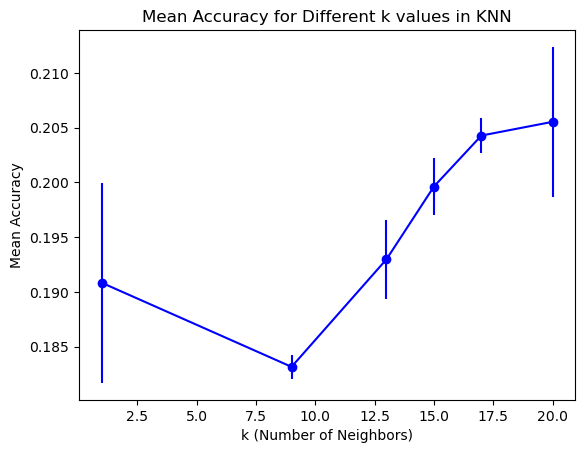

In [ ]:
k_values = [1, 9, 13, 15, 17, 20]  

mean_accuracies = []
std_devs = []

for k in k_values:
    knn = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=k))
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)  # Adjust the data and CV folds
    mean_accuracies.append(scores.mean())
    std_devs.append(scores.std())
    print(f'k={k}, Mean Accuracy: {scores.mean()}, Std: {scores.std()}')

plt.errorbar(k_values, mean_accuracies, yerr=std_devs, marker='o', linestyle='-', color='b')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy for Different k values in KNN')
plt.show()

In [ ]:
knn = MultiOutputClassifier(KNeighborsClassifier())

# Define the parameter grid to search
param_grid = {
    'estimator__n_neighbors': [9, 15, 17, 21],  
    'estimator__weights': ['uniform', 'distance'],
    'estimator__p': [1, 2],  
}

# Create GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Get the best model
best_knn_model = grid_search.best_estimator_



c:\Users\Sofia\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Sofia\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Sofia\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Sofia\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Sofia\miniconda3\Lib\site-packages\sklearn\metrics\_scor

Best Parameters: {'estimator__n_neighbors': 9, 'estimator__p': 1, 'estimator__weights': 'uniform'}
Best Score: nan
